In [2]:
# imports
import pickle
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
import lime
import lime.lime_tabular
import shap
from sklearn.inspection import permutation_importance
from typing import Tuple, Union, Optional, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from importlib import reload
import constants
import data_utils
import models
import training_and_selection
import plot_accuracies
import explanation_utils

In [3]:
reload(constants)
reload(models)
from constants import (
    SEED,
    NUM_SPLITS,
    INITIAL_CUTOFF,
    TOP,
    TARGET,
    MODEL_ACCURACIES_PATH,
    FILTERED_MODEL_ACCURACIES_PATH,
    TIME_LIMIT,
    TIME_LIMIT_CROSS_VALIDATION,
    RASHOMON_SETS_PATH,
    INITIAL_ACCURACIES_PATH,
    CHECKPOINT_PATH,
)
from models import MODELS, HYPERPARAMETERS

In [ ]:
reload(data_utils)
from data_utils import get_dataset

X, y = get_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=(SEED+1))
BASELINE = np.sum(y == 1) / np.sum(y == 0)

In [ ]:
reload(constants)
reload(training_and_selection)
from training_and_selection import get_rashomon_sets

rashomon_sets_params = get_rashomon_sets(
    models=MODELS,
    hyperparameters=HYPERPARAMETERS,
    X=X,
    y=y,
    initial_cutoff=0.15,
    top=0.04,
    initial_time_limit=50,
    cross_validation_time_limit=60,
    initial_path='results/initial_grid_search.csv',
    cross_validation_path='results/cross_validation_results.csv',
)
pickle.dump(rashomon_sets_params, open(RASHOMON_SETS_PATH, 'wb'))

408

In [251]:
reload(constants)
reload(explanation_utils)
from explanation_utils import EXPLANATION_FUNCS2, EXPLANATION_FUNCS3, run_all_explanations

explanations = run_all_explanations(
    MODELS,
    rashomon_sets_params,
    X_train,
    y_train,
    X_test,
    y_test,
    plot=False,
    path='results4/',
    explanation_funcs=EXPLANATION_FUNCS3
)


  0%|          | 0/11 [00:00<?, ?it/s]/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:162: UserWarning:

Device used : cuda

/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:258: UserWarning:

No early stopping will be performed, last training weights will be used.



 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.50277 |  0:00:10s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.38805 |  0:00:20s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.49854 |  0:00:17s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.38433 |  0:00:35s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.49557 |  0:00:17s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.38605 |  0:00:34s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.54622 |  0:00:19s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.42903 |  0:00:38s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.57128 |  0:00:06s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.38697 |  0:00:11s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.50902 |  0:00:18s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.39788 |  0:00:36s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.54237 |  0:00:10s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.39845 |  0:00:19s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.56786 |  0:00:06s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.38842 |  0:00:12s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.49157 |  0:00:17s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.3791  |  0:00:34s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.51754 |  0:00:19s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.40485 |  0:00:38s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



epoch 0  | loss: 0.51482 |  0:00:19s


 batches:   0%|          | 0/301 [00:00<?, ?it/s]

epoch 1  | loss: 0.39844 |  0:00:37s


/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

In [232]:
for model_explanations in explanations:
    agg_explanation = None
    for (model, explanation), exp_lime in zip(model_explanations['shap'].items(), model_explanations['lime'].values()):
        # print(explanation._s.__dict__.keys())
        if agg_explanation is None:
            agg_explanation = explanation
            # model_name = model
        else:
            agg_explanation = agg_explanation + explanation
        # break
        # print(explanation.values)
        # plt.title(model[0])
        # exp_lime.as_pyplot_figure()
    agg_explanation.values = np.array(agg_explanation.values) / len(model_explanations['shap'])
    # agg_explanation.data = np.array(agg_explanation.data) / len(model_explanations['shap'])
    agg_explanation.data = explanation.data

    shap.plots.waterfall(agg_explanation[0])
    shap.summary_plot(agg_explanation)
    
    # plt.plot()

KeyError: 'shap'

In [ ]:
import plotly.graph_objects as go

for model_explanations in explanations:
    agg_explanation = dict()
    cnt_explanation = dict()
    for (model, kwargs), exp_lime in model_explanations['lime'].items():
        for label, value in exp_lime.as_list():
            agg_explanation[label] = agg_explanation.get(label, 0) + value
            cnt_explanation[label] = cnt_explanation.get(label, 0) + 1
        # break
        # print(explanation.values)
        # exp_lime.as_pyplot_figure()
        # plt.title(model)
        # plt.show()
        
    for label in cnt_explanation.keys():
        agg_explanation[label] /= cnt_explanation[label]
    
    df = pd.DataFrame({
        'Average weights': pd.Series(agg_explanation),
        'Feature count': pd.Series(cnt_explanation)
    })

    # fig = go.Figure([go.Bar(
    #     y=list(agg_explanation.keys()),
    #     x=list(agg_explanation.values()),
    #     orientation='h'
    # )])
    # fig.update_layout(width=900, height=500)
    # fig.show()
    for c in df.columns:
        fig = go.Figure()
        fig.add_trace(go.Bar(
            y=df.index,
            x=df[c],
            orientation='h',
            # mode='markers',
            # xaxis='x2'
        ))
        fig.update_layout(
            title=model,
            width=900,
            height=500,
            xaxis={'title': c}
        )
        fig.show()

exp_lime.__dict__
exp_lime.as_list()

In [238]:
import plotly.express as px
from scipy.stats import entropy

def calculate_entropy(values):
    values = values[values > 0]
    probabilities = values / np.sum(values)
    return entropy(probabilities, base=2)

colors = px.colors.qualitative.Plotly[:3]
print(colors)
fig_entropy = go.Figure()
for i, model_explanations in enumerate(explanations):
    model_name = next(iter(model_explanations['vip_female'].keys()))[0]
    entropies = []
    for (model, kwargs), vip in model_explanations['vip_female'].items():
        entropies.append(calculate_entropy(vip))

    fig_entropy.add_trace(go.Box(
        x=[model_name for _ in entropies],
        y=entropies,
        # orientation='h',
        # mode='markers',
        name=model_name
    ))

    # fig_entropy.add_hline(y=np.mean(entropies), line_color=colors[i])

    avg_vip = sum(model_explanations['vip_female'].values())
    avg_vip = avg_vip.sort_values().iloc[-15:]
    # print(avg_vip.iloc[-10:].index)
    fig = go.Figure([go.Bar(
        y=avg_vip.index,
        x=avg_vip,
        orientation='h',
    )])
    fig.update_layout(
        title=f'{model_name} feature importance for men',
        width=600,
        height=500,
        xaxis={'title': 'Feature importance'}
    )
    fig.show()


fig_entropy.update_layout(
    title='Entropy of feature importances across models',
    width=600,
    height=500,
    yaxis={'title': 'Entropy base 2 value'},
    showlegend=False,
)
# fig_entropy.show()

['#636EFA', '#EF553B', '#00CC96']


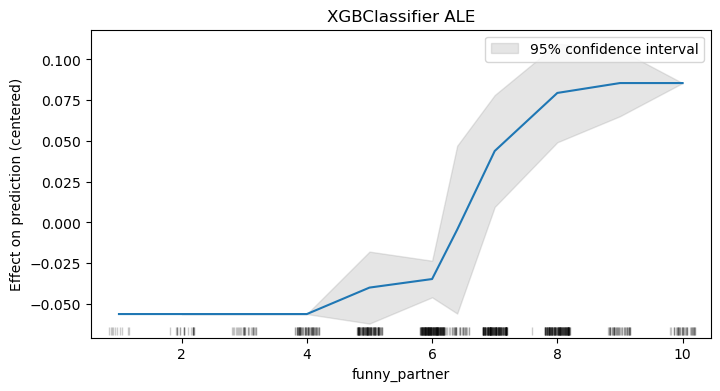

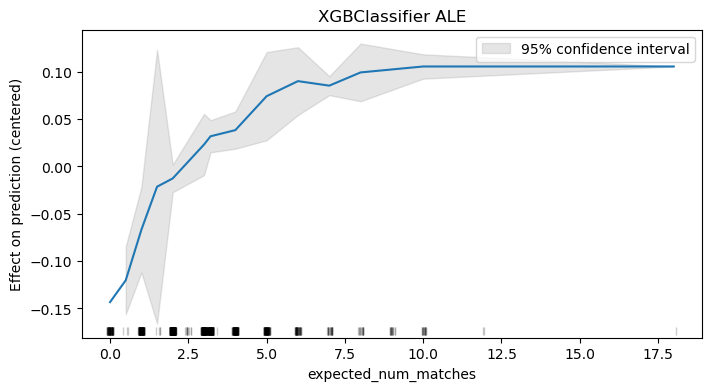

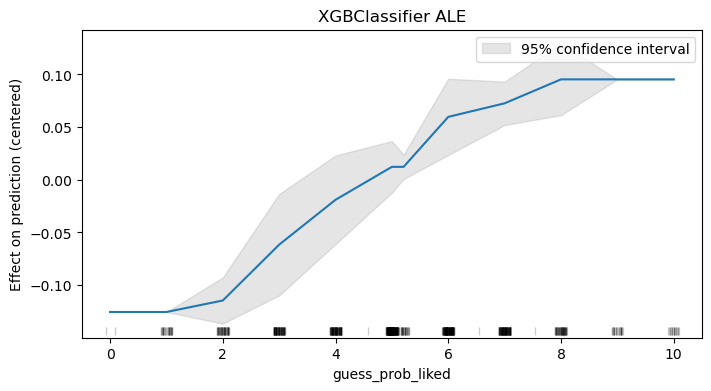

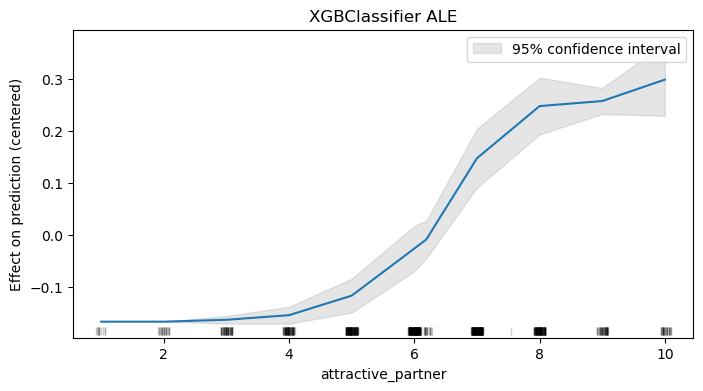

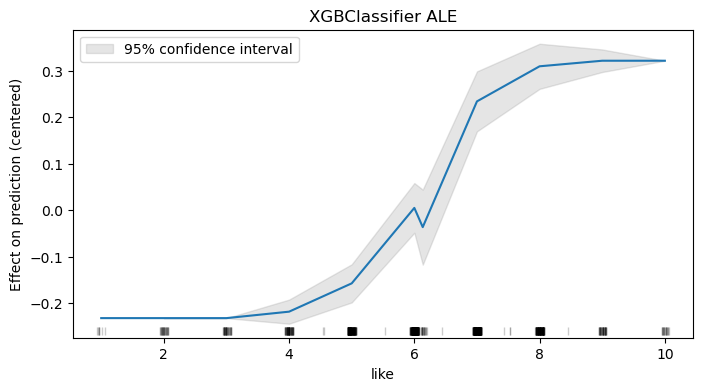

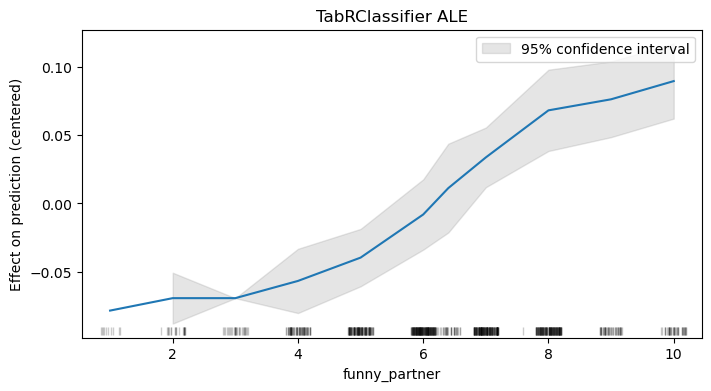

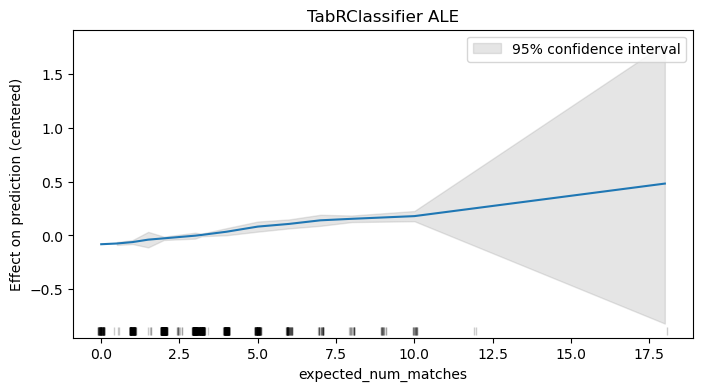

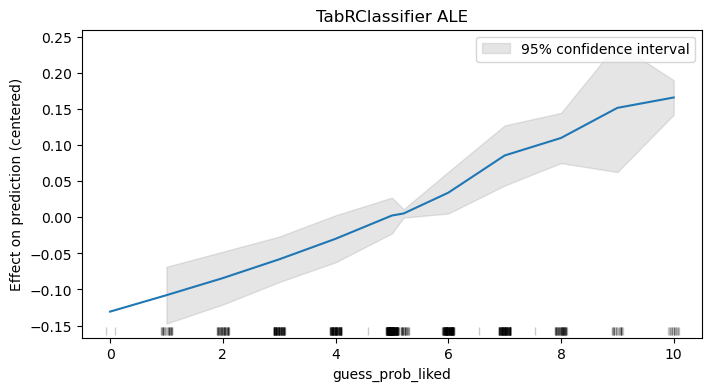

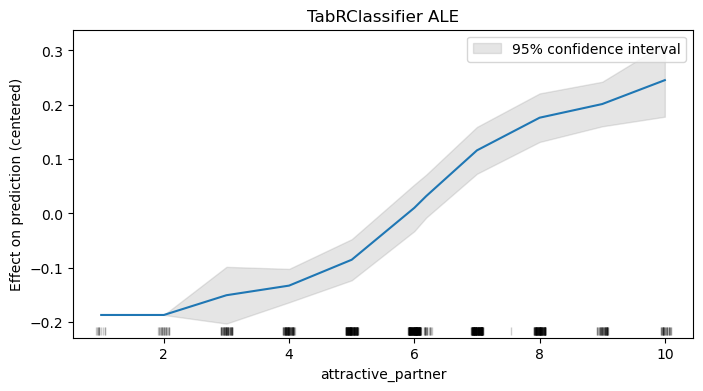

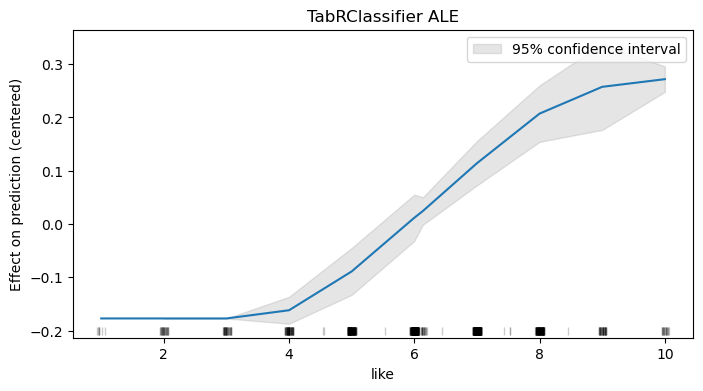

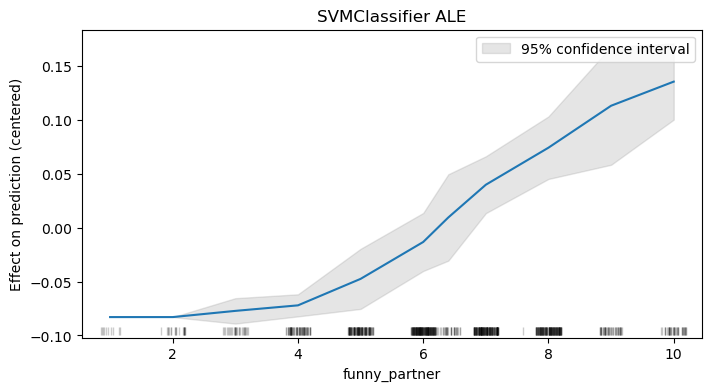

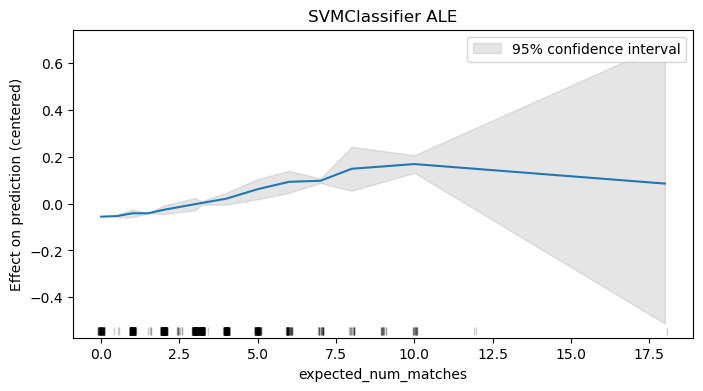

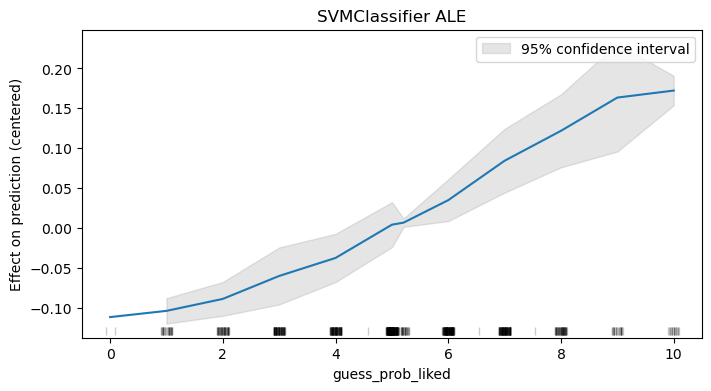

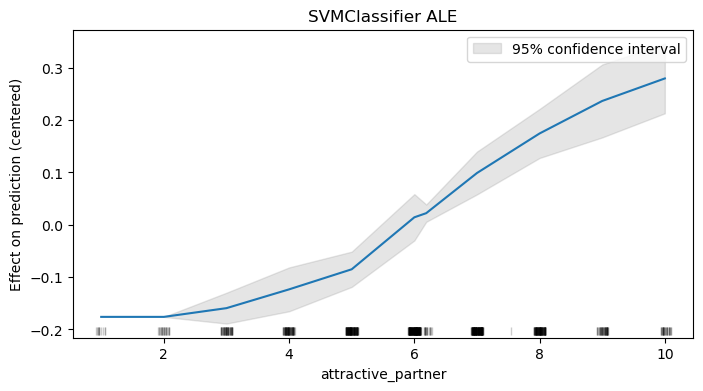

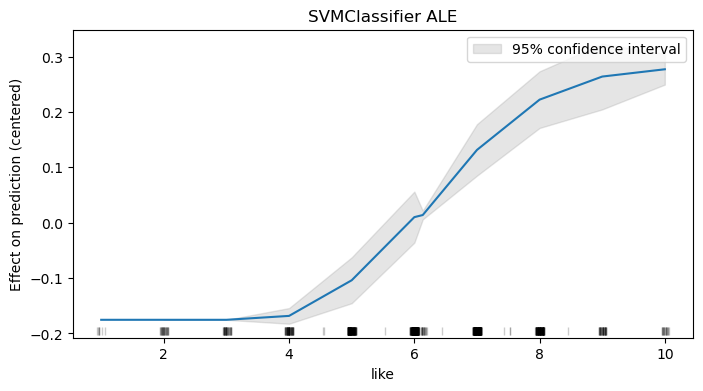

In [243]:
from PyALE._src.ALE_1D import plot_1D_continuous_eff

arg_plot = {
    "X": X_test,
    "fig": None,
    "ax": None,
}

for model_explanations in explanations:
    ale_agg = dict()
    for (model, kwargs), explanation in model_explanations['ale'].items():
        for feature, feature_ale in explanation.items():
            if feature in ale_agg:
                ale_agg[feature] = ale_agg[feature].add(feature_ale)
            else:
                ale_agg[feature] = feature_ale
        # print(ale_agg['like'].iloc[5:7])


    for feature, feature_ale in ale_agg.items():
        # print(feature_ale.shape)
        feature_ale /= len(model_explanations['ale'].keys())
        plot_1D_continuous_eff(feature_ale, **arg_plot)
        plt.title(model + ' ALE')
        plt.show()
        # break
    # break

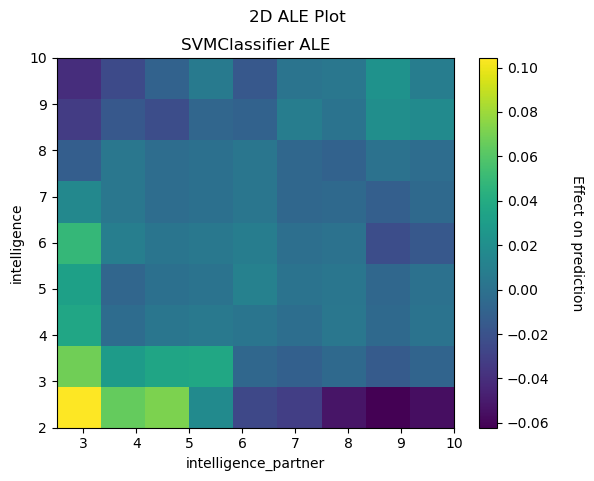

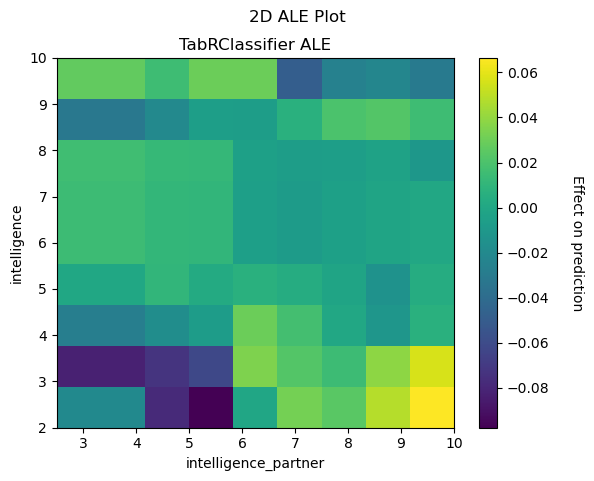

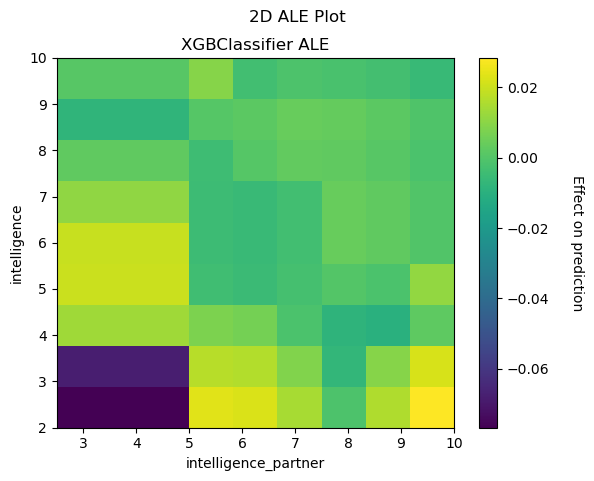

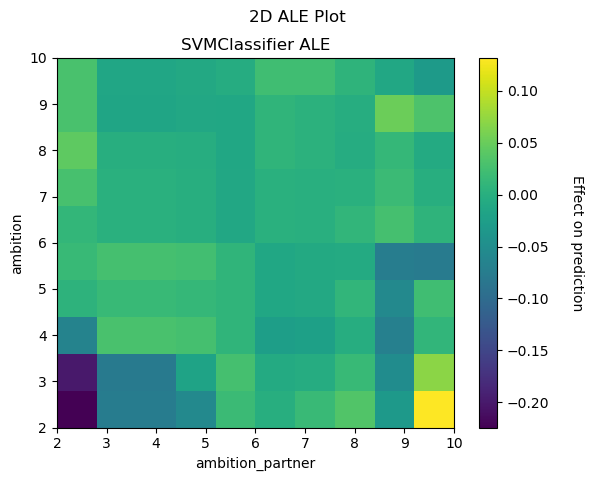

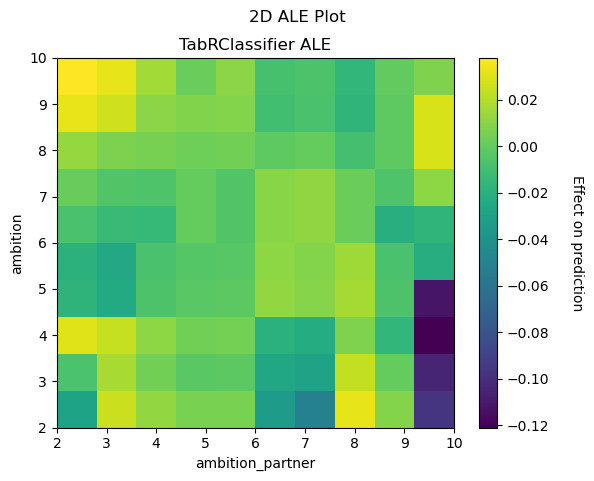

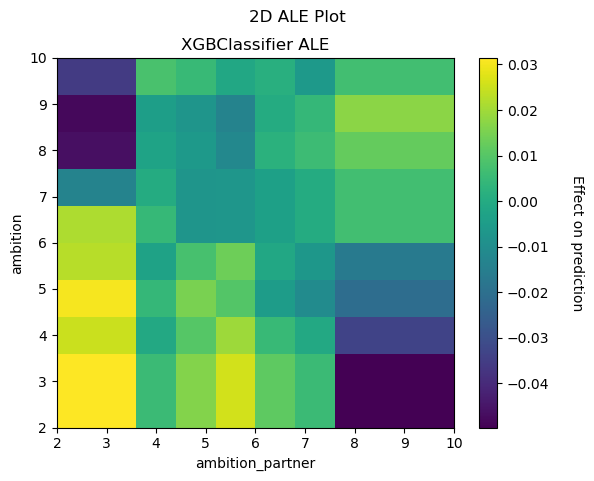

In [252]:
from PyALE._src.ALE_2D import plot_2D_continuous_eff
from matplotlib import pyplot as plt

arg_plot = {
    # "contour": False,
    "fig": None,
    "ax": None,
}

for experiment_name in ['ale0int', 'ale0amb']:
    for model_explanations in explanations:
        ale_agg = None
        for (model, kwargs), explanation in model_explanations[experiment_name].items():
            if ale_agg is None:
                ale_agg = explanation
            else:
                ale_agg = ale_agg.add(explanation)

        ale_agg /= len(model_explanations[experiment_name].keys())
        plot_2D_continuous_eff(ale_agg, **arg_plot)
        plt.title(model + ' ALE')
        plt.show()
    # break
    # break

In [ ]:
pd.set_option('display.max_columns', 70)
X_test.describe()